<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch5_4_pg_303~310(LinearRegression%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%B3%B4%EC%8A%A4%ED%84%B4_%EC%A3%BC%ED%83%9D_%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

---



---



# LinearRegression 클래스 - Ordinary Least Squares
- LinearRgression 클래스는 예측값과 실제 값의 RSS를 최소화해 OLS 추정 방식으로 구현한 클래스, fit() 메서드로 X,y 배열을 입력 받으면 회귀계수인 W를 coef_ 속성에 저장

In [4]:
# class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_x=True, n_jobs=1)

# 입력 파라미터
- fit_intercept는 불린 값으로 디폴트는 True, 절편 값을 계산할 것인지 아닌지를 지정함. 만일 False이면 intercept가 사용되지 않고 0으로 지정
- normaliz: 불린 값으로 디폴트는 False. fit_intercept가 False인 경우에는 파라미터가 무시됨. True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화

# 속성
- coef_: fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성
- intercept_: intercept 값


# Ordinary Least Squares
- 회귀 계수 계산은 입력 피처의 독립서에 많은 영향을 받음, 피처간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해짐(다중공선성) -> 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용
- 많은 피처가 다중 공선성 문제를 갖고 있다면, PCA를 통해 차원 축소를 수행하는 것도 고려해 볼 수 있음. 

# 회귀 평가 지표
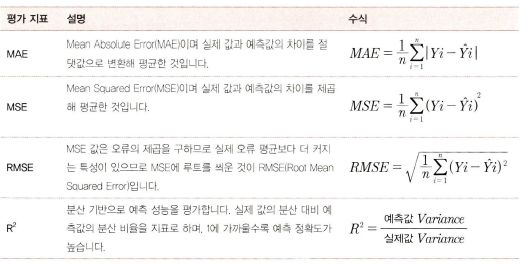

- 사이킷런은 rmse를 제공하지 않아, MSE에 제곱은을 씌워 계산하는 함수를 직접 만들어야 함. 
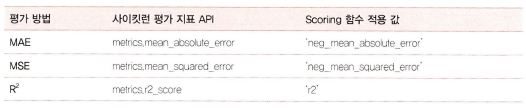

- cross_val_score, GridSearchCV와 같은 Scoring 함수에 회귀 평가 지표를 적용할 때 유의할 점: neg(음수)의 의미 -> 음수로 반환하는 이유는, Scoring 함수가 score 값이 클수록 좋은 평가 결과로 자동 평가하기 때문
- 그런데, 실제 값과 예측값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 의미의 모델 -> Scoring 적용을 위한 보정이 필요한 것 = neg 적용

# LinearRegression을 이용해 보스턴 주택 가격 회귀 구현
- 사이킷런에 내장된 데이터 세트인 보스턴 주택 가격 데이터를 이용.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data,columns=boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격. 이를 price 칼럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기:',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- null 값 없으며, 모두 float형. 

#각 칼럼이 회귀 결과에 미치는 영향 어느 정도인지 시각화

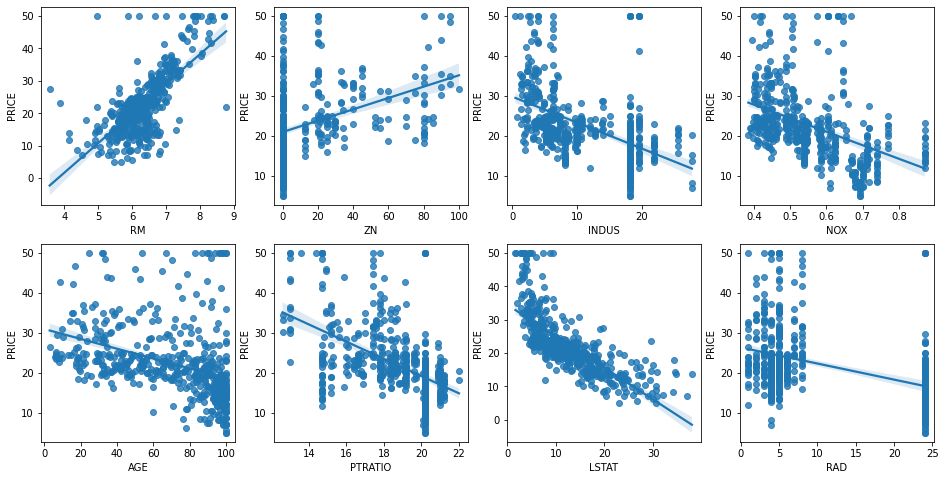

In [7]:
# 2개의 행과 4개의 열을 가진 subplots를 이용 axs는 4x2개의 ax를 가짐
fig,axs = plt.subplots(figsize=(16,8),ncols=4,nrows=2) # ncols: 열 방향으로 위치할 그래프의 개수, nrows: 행 방향으로 위치할 그래프의 개수
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i,feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  # 시본의 regplot를 이용해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x=feature,y='PRICE',data=bostonDF,ax=axs[row][col])

- 다른 칼럼보다 RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
- RM은 양 방향의 선형성이 가장 크다
- LSTAT은 음 방향의 선형성이 가장 크다

#LienarRegression 클래스 이용해 보스턴 주택 가격의 회귀모델 만들기

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_data,y_target,test_size=0.3,random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train,y_train)

y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test,y_preds)
rmse=np.sqrt(mse)

print('MSE:{0:.3f},RMSE:{1:.3f}'.format(mse,rmse))
print('Variance score:{0:.3f}'.format(r2_score(y_test,y_preds)))

MSE:17.297,RMSE:4.159
Variance score:0.757


# 절편과 회귀 계수 값을 보기

In [10]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

절편 값: 40.99559517216477
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


# coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑하고, 높은 값 순으로 출력: pandas Serie의 sort_values 이용

In [13]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Serie로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1),index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- RM이 양의 값으로 회귀 계수가 가장 크며, NOX 피처의 회귀 계수 - 값이 너무 커 보임. 
- 차츰 최적화를 수행하면서 피처 회귀계수의 변화를 보겠음.

#교차 검증으로 MSE와 RMSE를 측정
- 5개 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE와 RMSE를 측정
- 사이킷런은 RMSE를 제공하지 않으므로, MSE 수치 결과를 RMSE로 변환해야 함. 
- cross_val_score()의 인자로 scoring='neg_mean_squared_error'로 Scoring 함수를 호출하면 모델에서 계산된 MSE 값에 -1를 곱해 반환함. 
- 따라서, cross_val_score()에서 반환된 값에 다시 -1을 곱해야 양의 값인 원래 모델에서 계산된 MSE 값이 됨
- 이렇게 다시 변환된 MSE 값에 넘파이의 sqrt()함수를 적용해 RMSE를 구할 수 있음

In [14]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score() 로 5폴드 세트로 MSE 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
